# 😀/😞 Sentiment Analysis on Restaurant Reviews using NLP

*This note book builds an end-to-end classification model uisng NLP, Naive Bayes.*

### 1.Problem

Identify whether the reviews of a restaurant made by customers are postive or negative. 

### 2.Data
The data is collected from two sources.
  * Kaggle : Restaurant Customer Reviews - https://www.kaggle.com/vigneshwarsofficial/reviews
  * Kaggle : Restaurant Reviews in Dhaka, Bangladesh - https://www.kaggle.com/tuxboy/restaurant-reviews-in-dhaka-bangladesh


### 3.Evaluation
Evaluation is done on basis of metrics like accuracy score.

### 4.Features
Some information about data:
* Entire data is in text format, so its better to use NLP for developing our ML models.
* Overall, we have 17000 reviews (combining both the datasets).
* We have two labels(columns) namely:
  * Review : which is the review itself.
  * Liked : which tells whether the review is positive or negative.
    * 1 - for positive
    * 0 - for negative
* Text language is english.

## Connect Google Drive to Google Colab

In [50]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Get your workspace ready

In [261]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import re
import pickle

# Other imports would be imported at specific necessary cells

## Data Preprocessing

We will do the pre-processing in three steps:
  * Process data in dataset 1
  * Process data in dataset 2
  * Combine both the datasets

Preprocessing Dataset 1

In [187]:
# Load the dataset into dataframe
df1 = pd.read_csv("/content/drive/My Drive/Restaurant Reviews/reviews_1.tsv", delimiter='\t')

In [190]:
df1.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [191]:
# Know the shape of the dataframe
df1.shape

(1000, 2)

In [192]:
# Know the columns of the dataframe
df1.columns

Index(['Review', 'Liked'], dtype='object')

In [193]:
# Change the column names
df1.columns = ['Review', 'Sentiment']

In [194]:
# Know the data types of all columns
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Preprocessing Dataset 2

In [195]:
# Load the dataset into dataframe
df2 = pd.read_csv("/content/drive/My Drive/Restaurant Reviews/reviews_2.csv")

In [196]:
df2.head()

,Review Text,Review,Recommends
0,"Friendly staff, good food and homely environme...",NaN,True
1,Well...The Food was Good___Intrerior design is...,NaN,True
2,The man who is foodie like me for him arabian ...,5.0,NaN
3,ordered pizza and they were unable to serve th...,NaN,False
4,This place is too much comfortable & food is d...,4.0,NaN


In [151]:
df2.shape

(16597, 3)

In [152]:
df2.columns

Index(['Review Text', 'Review', 'Recommends'], dtype='object')

In [197]:
# remove records with empty ratings
df2.dropna(subset=['Review'], inplace=True)
df2['Review'].isna().sum()

0

In [198]:
# Remove unnecessary columns
df2.drop(['Recommends'], axis=1, inplace=True)

In [199]:
df2[df2['Review'] == 3].sample(10)

,Review Text,Review
14256,যশোর বিজ্ঞান প্রযুক্তিতে ভর্তি বাণিজ্য ও পরীক্...,3.0
8855,what r the bill payment system of star kabab? ...,3.0
9468,Had a dinner reservation for 3 and after readi...,3.0
8941,"It's good, but not great though. Good environm...",3.0
371,Good,3.0
7178,Well let's put it this way. This is definitely...,3.0
13845,Why on Earth was Chittagong's one closed down?...,3.0
10344,Good food Good life,3.0
9137,A sacred place to put off your shoes to enjoy ...,3.0
14622,ওকে,3.0


In [200]:
# create a function to map stars to sentiment
# 0,1,2 stars is considered as negative review (0)
# 3, 4,5 stars is considered as positive (1) [since most of the reviews with 3 are food from general inspection, we can consider 3 rating as positive]

def map_sentiment(stars_received):
  if stars_received <=2 :
    return 0
  else:
    return 1

In [201]:
# mapping stars to sentiment
df2['Sentiment'] = [map_sentiment(x) for x in df2['Review']]

In [202]:
df2.tail()

,Review Text,Review,Sentiment
16588,The rice they served was cool. Taste very bad ...,1.0,0
16590,I like their food. No matter what they never d...,4.0,1
16592,Firstly their ac didn't work just useless and ...,1.0,0
16594,Best Thai soup of the town,5.0,1
16596,I liked the place.the food was good and so the...,4.0,1


In [203]:
# Sentiment distribution across df
df2['Sentiment'].value_counts()

1    11731
0     2947
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Sentiment distribution in df')

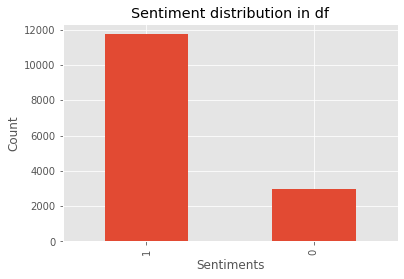

In [204]:
# plotting the sentiment distribution across df

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

data = pd.value_counts(df2['Sentiment'])
data.plot.bar()
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment distribution in df')

Number of rows are not equally balanced across the both sentiments. So, to skip this problem and make a balanced dataset we will take first 2900 records for each sentiment.

In [205]:
# Function to create a dataframe which has equal records for all categories

def create_balanced_df(full_df, number_of_records):
  bal_df_positive = full_df[full_df['Sentiment'] == 1].head(number_of_records)
  bal_df_negative = full_df[full_df['Sentiment'] == 0].head(number_of_records)
  bal_df = pd.concat([bal_df_positive, bal_df_negative])
  return bal_df

In [206]:
df2_bal = create_balanced_df(df2, 2900)

In [207]:
df2_bal.head()

,Review Text,Review,Sentiment
2,The man who is foodie like me for him arabian ...,5.0,1
4,This place is too much comfortable & food is d...,4.0,1
6,I check it out like a second home of mine...fe...,3.0,1
8,"you guys are awesome & I just love your ""offer...",5.0,1
10,Went there after referred by a friend. Tried t...,5.0,1


In [208]:
df2_bal.shape

(5800, 3)

In [209]:
# Remove the 'Review' column
df2_bal.drop(['Review'], axis=1, inplace=True)
df2_bal.head()

,Review Text,Sentiment
2,The man who is foodie like me for him arabian ...,1
4,This place is too much comfortable & food is d...,1
6,I check it out like a second home of mine...fe...,1
8,"you guys are awesome & I just love your ""offer...",1
10,Went there after referred by a friend. Tried t...,1


In [210]:
# Change the column names of df2 to match with df1
df2_bal.columns = ['Review', 'Sentiment']

Merge both the dataframes df1 and df2

In [211]:
# merge df1 and df2
df = pd.concat([df1,df2_bal])

In [212]:
df.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [213]:
# Sentiment distribution across df
df['Sentiment'].value_counts()

1    3400
0    3400
Name: Sentiment, dtype: int64

In [214]:
# Save the final dataset into a csv
df.to_csv("/content/drive/My Drive/Restaurant Reviews/reviews_final.csv", index=False)

## Clean the data
  * Remove all the special characters
  * Change all the characters to lower case
  * Tokenize each reviews into words
  * Remove stopwords
  * Perform Stemming / Lemmatization

In [215]:
# load the final dataset into a pandas dataframe
df = pd.read_csv("/content/drive/My Drive/Restaurant Reviews/reviews_final.csv")

In [216]:
df.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [217]:
# Import other stopwords and PortetStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()

# Function for cleaning the reviews
def clean_text(text):

  # cleaning special characters from reviews
  review = re.sub(pattern='[^a-zA-Z]', repl=' ', string=text)

  # converting each review into lowercase
  review = review.lower()

  # tokenizing the review into words
  review_words = review.split()

  # removing the stop words
  review_words = [word for word in review_words if word not in set(stopwords.words('english'))]

  # stemming the words
  review_words = [ps.stem(word) for word in review_words]

  # joining the stemmed words
  review = ' '.join(review_words)

  return review


# clean text data
df["Review_cleaned"] = df["Review"].apply(lambda x: clean_text(x))

In [218]:
df.head()

,Review,Sentiment,Review_cleaned
0,Wow... Loved this place.,1,wow love place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasti textur nasti
3,Stopped by during the late May bank holiday of...,1,stop late may bank holiday rick steve recommen...
4,The selection on the menu was great and so wer...,1,select menu great price


## Feature Engineering

We use vader, which uses lexicon of words to find which ones are positive and negative. It takes into account the context of the sentences and determine the below four scores.
  * a neutrality score
  * a positivity score
  * a negativity score
  * an overall score that summarizes the previous scores

We will integrate these four values as features in our dataset.

In [219]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
df['sentiments_tmp'] = df["Review"].apply(lambda x: sia.polarity_scores(x))
df = pd.concat([df.drop(['sentiments_tmp'], axis=1), df['sentiments_tmp'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Next we add some metrics to each review
* Number of characters in each review
* Number of words in each review

In [220]:
# add number of characters column
df["nb_chars"] = df['Review'].apply(lambda x : len(x))

# add number of words column
df["nb_words"] = df["Review"].apply(lambda x : len(x.split(" ")))

In [221]:
df.head()

,Review,Sentiment,Review_cleaned,neg,neu,pos,compound,nb_chars,nb_words
0,Wow... Loved this place.,1,wow love place,0.000,0.435,0.565,0.5994,24,4
1,Crust is not good.,0,crust good,0.445,0.555,0.000,-0.3412,18,4
2,Not tasty and the texture was just nasty.,0,tasti textur nasti,0.340,0.660,0.000,-0.5574,41,8
3,Stopped by during the late May bank holiday of...,1,stop late may bank holiday rick steve recommen...,0.093,0.585,0.322,0.6908,87,15
4,The selection on the menu was great and so wer...,1,select menu great price,0.000,0.728,0.272,0.6249,59,12


Extracting vector representations for each review

In [222]:
# create doc2Vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Review_cleaned"].apply(lambda x: x.split(" ")))]

# train doc2vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df["Review_cleaned"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

In [264]:
# save the trained doc2vec model
pickle.dump(model, open('/content/drive/My Drive/Restaurant Reviews/doc2vec-model.pkl', 'wb'))

Add TF-IDF values for every word and every document

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10)
tfidf_result = tfidf.fit_transform(df['Review_cleaned']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

In [224]:
df.head()

,Review,Sentiment,Review_cleaned,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_abar,word_abl,word_absolut,word_ac,word_accept,word_accord,word_actual,word_ad,word_add,word_addit,word_advertis,word_afford,word_age,word_ago,word_ahead,word_air,word_ajk,word_ak,word_akta,word_al,word_allah,word_almost,word_along,word_alreadi,word_alright,word_also,...,word_wastag,word_watch,word_water,word_way,word_wedg,word_week,word_welcom,word_well,word_went,word_whenev,word_white,word_whole,word_wife,word_wing,word_wish,word_within,word_without,word_wonder,word_wont,word_word,word_work,word_world,word_wors,word_worst,word_worth,word_worthi,word_would,word_wow,word_wrap,word_write,word_wrong,word_wrost,word_yammi,word_ye,word_year,word_yesterday,word_yet,word_yummi,word_zero,word_zone
0,Wow... Loved this place.,1,wow love place,0.000,0.435,0.565,0.5994,24,4,0.043681,-0.084319,0.068132,-0.084563,0.037188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Crust is not good.,0,crust good,0.445,0.555,0.000,-0.3412,18,4,0.010130,-0.032990,0.059766,0.086722,-0.015877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Not tasty and the texture was just nasty.,0,tasti textur nasti,0.340,0.660,0.000,-0.5574,41,8,-0.060891,-0.168801,0.029523,-0.088486,0.038103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Stopped by during the late May bank holiday of...,1,stop late may bank holiday rick steve recommen...,0.093,0.585,0.322,0.6908,87,15,-0.142140,-0.324079,0.231268,-0.077509,0.028429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The selection on the menu was great and so wer...,1,select menu great price,0.000,0.728,0.272,0.6249,59,12,0.030338,-0.038682,0.039114,0.015122,-0.040744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
df.shape

(6800, 1154)

In [265]:
# save the trained tfidf model
pickle.dump(tfidf, open('/content/drive/My Drive/Restaurant Reviews/tfidf-model.pkl', 'wb'))

## Exploratory Data Analysis

### Word Cloud

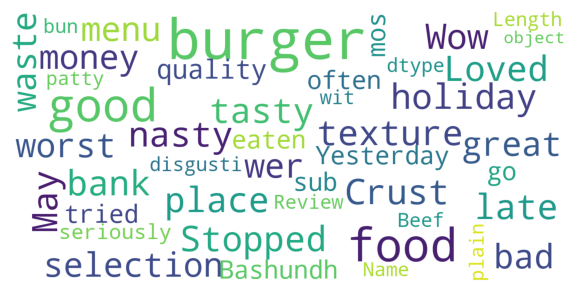

In [226]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["Review"])

### Create test and train sets


In [227]:
# feature selection
label = 'Sentiment'
ignore_columns = [label, 'Review', 'Review_cleaned']

features = [c for c in df.columns if not c in ignore_columns]

# split the data into test and train sets
from sklearn.model_selection import train_test_split
X, y = df[features], df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [228]:
(X_train.shape, y_train.shape)

((5440, 1151), (5440,))

In [229]:
(X_test.shape, y_test.shape)

((1360, 1151), (1360,))

### Model Building

Here we are using Naive Bayes classifier model, it works on probability.

In [230]:
# import Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# create an instance for MultinomialNB
rf = RandomForestClassifier(random_state=42)

# Fit the data to the model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [231]:
## Feature Importance

feature_importances_df = pd.DataFrame({'feature':features, 'importance':rf.feature_importances_}).sort_values('importance', ascending=False)
feature_importances_df.head(20)

,feature,importance
2,pos,0.146962
3,compound,0.139063
0,neg,0.077569
1,neu,0.029493
7,doc2vec_vector_1,0.022526
6,doc2vec_vector_0,0.022289
4,nb_chars,0.021697
625,word_love,0.019437
5,nb_words,0.019144
8,doc2vec_vector_2,0.019022


### Predict test results

In [232]:
y_preds = rf.predict(X_test)

### Evaluation

In [233]:
# Calculate Accuracy, Precision and Recall
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracy = accuracy_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)

print("///---Scores---///")
print('Accuracy Score is : {}%'.format(round(accuracy*100,2)))
print('Precision Score is : {}'.format(round(precision,2)))
print('Recall Score is : {}'.format(round(recall,2)))

///---Scores---///
Accuracy Score is : 88.97%
Precision Score is : 0.91
Recall Score is : 0.87


Calculate evaluation metrics with cross_val_score

In [234]:
# import cross_val_score from sklearn
from sklearn.model_selection import cross_val_score

# Create a new classifier
classifier = RandomForestClassifier()

# Cross-Validated Accuracy
accuracy_cv = np.mean(cross_val_score(classifier,
                                      X,
                                      y,
                                      cv=5,
                                      scoring='accuracy'))

# Cross-Validated Precision
precision_cv = np.mean(cross_val_score(classifier,
                                      X,
                                      y,
                                      cv=5,
                                      scoring='precision'))

# Cross-Validated Recall
recall_cv = np.mean(cross_val_score(classifier,
                                      X,
                                      y,
                                      cv=5,
                                      scoring='recall'))

print("///---Cross-Validated Scores---///")
print('Accuracy Score is : {}%'.format(round(accuracy_cv*100,2)))
print('Precision Score is : {}'.format(round(precision_cv,2)))
print('Recall Score is : {}'.format(round(recall_cv,2)))

///---Cross-Validated Scores---///
Accuracy Score is : 87.41%
Precision Score is : 0.89
Recall Score is : 0.86


### Confusion Matrix

In [235]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_preds)
cm

array([[622,  59],
       [ 91, 588]])

Text(33.0, 0.5, 'Actual Values')

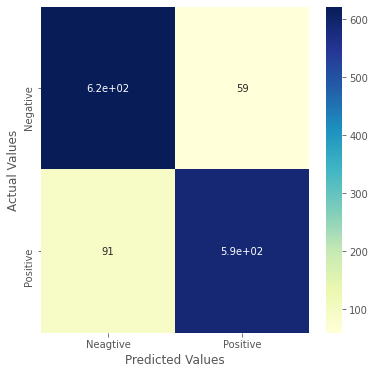

In [236]:
# Plotting confusion matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Neagtive', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

### Hyperparameter Tuning using RandomizedSearchCV

In [ ]:
# import RandomizedSearchCV from sklearn
from sklearn.model_selection import RandomizedSearchCV

# Create a hyperparameter grid for our classifier
param_grid = {'alpha':np.arange(0.1,1.1,0.1)}

# Setup hyperparameter search for RandomForestClassifier classifier
rs = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=param_grid,
                        cv=5,
                        n_iter=10,
                        verbose=True,
                        random_state=0)

# Fit the hyperparameter search
rs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                           fit_prior=True),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring=None, verbose=True)

In [ ]:
rs.best_params_

{'alpha': 0.8}

In [ ]:
rs_y_preds = rs.predict(X_test)
print(classification_report(y_test, rs_y_preds))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       681
           1       0.86      0.90      0.88       679

    accuracy                           0.88      1360
   macro avg       0.88      0.88      0.88      1360
weighted avg       0.88      0.88      0.88      1360



In [ ]:
rs.score(X_test, y_test)

0.8757352941176471

In [257]:
# Re-train the classifier with best params derived from Hyperparameter Tuning.
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [262]:
# save the trained classifier to use it predictions anywhere else
pickle.dump(classifier, open('/content/drive/My Drive/Restaurant Reviews/restaurant-sentiment-rf-model.pkl', 'wb'))

## Making predictions for real-world reviews

Create a function which will take a sample review as input and give prediction as output using our trained classifier

In [280]:
def predict_sentiment(sample_review):

  sample_review_cleand = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sample_review)
  sample_review_cleand = sample_review_cleand.lower()
  sample_review_words = sample_review_cleand.split()
  sample_review_words = [word for word in sample_review_words if word not in set(stopwords.words('english'))]
  ps = PorterStemmer()
  sample_review_words = [ps.stem(word) for word in sample_review_words]
  sample_review_cleand = ' '.join(sample_review_words)
  sample_df = pd.DataFrame()
  sample_df['Review'] = [sample_review]
  sample_df['Review_cleaned'] = [sample_review_cleand]
  sample_df['sentiments_tmp'] = sample_df["Review"].apply(lambda x: sia.polarity_scores(x))
  sample_df = pd.concat([sample_df.drop(['sentiments_tmp'], axis=1), sample_df['sentiments_tmp'].apply(pd.Series)], axis=1)
  sample_df["nb_chars"] = sample_df['Review'].apply(lambda x : len(x))
  sample_df["nb_words"] = sample_df["Review"].apply(lambda x : len(x.split(" ")))
  sample_doc2vec_df = sample_df["Review_cleaned"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
  sample_doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in sample_doc2vec_df.columns]
  sample_df = pd.concat([sample_df, sample_doc2vec_df], axis=1)
  sample_tfidf_result = tfidf.transform(sample_df['Review_cleaned']).toarray()
  sample_tfidf_df = pd.DataFrame(sample_tfidf_result, columns=tfidf.get_feature_names())
  sample_tfidf_df.columns = ["word_" + str(x) for x in sample_tfidf_df.columns]
  sample_tfidf_df.index = sample_df.index
  sample_df = pd.concat([sample_df, sample_tfidf_df], axis=1)
  sample_features = [c for c in sample_df.columns if not c in ['Review', 'Review_cleaned']]

  return classifier.predict(sample_df[sample_features])

[0]


In [292]:
# Predicting values
sample_review = 'The food was good'
print(type(predict_sentiment(sample_review)[0]))

if predict_sentiment(sample_review) == 1:
  print('This is a POSITIVE REVIEW')
else:
  print('This is NEGATIVE REVIEW')


<class 'numpy.int64'>
This is a POSITIVE REVIEW


In [270]:
# Predicting values
sample_review = 'Food was pretty bad and the service was very slow.'

if predict_sentiment(sample_review) == 1:
  print('This is a POSITIVE REVIEW')
else:
  print('This is NEGATIVE REVIEW')

This is NEGATIVE REVIEW


In [271]:
# Predicting values
sample_review = 'The food was absolutely wonderful, from preparation to presentation, very pleasing.'

if predict_sentiment(sample_review) == 1:
  print('This is a POSITIVE REVIEW')
else:
  print('This is NEGATIVE REVIEW')

This is NEGATIVE REVIEW
